In [4]:
!pip3 install numpy
!pip3 install graphviz
!pip3 install matplotlib


  Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (163 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.0.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp312-cp312-macosx_11_0_arm64.whl (251 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.54.1-cp312-cp312-macosx_11_0_arm64.whl (2.3 MB)
Using cached kiwisolver-1.4.7-cp312-cp312-macosx_11_0_arm64.whl (63 kB)
Using cached pillow-11.0.0-cp312-cp312-macosx_11_0_arm64.whl (3.0 MB)
Using cached pyparsing-3.2.0-py3-none-any.

In [5]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
print("hello")

hello


In [7]:
def f(x):
    return 3*x**2 - 4*x + 5

In [8]:
f(3.0)

20.0

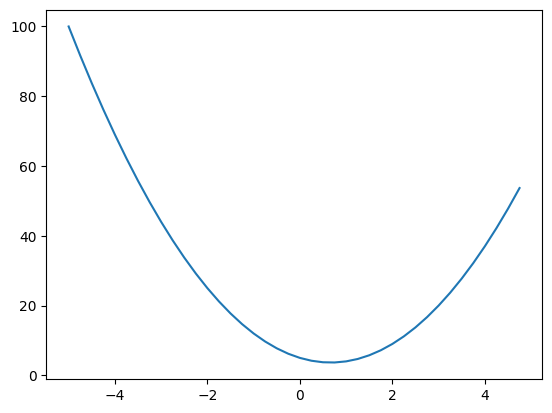

In [9]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [169]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #0 means no effect at initialization, doesn't affect the output. grad - gradient
        self._backward = lambda: None            #this will do the chainrule 
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) #if its a value object, leave as is, else wrap it
        out = Value(self.data + other.data, (self , other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self , other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "this can only handle int/floa powers for now lol"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad #other = n in x^n -> n*x^(n-1)
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): #self / other
        return self * other**-1
    
    def __neg__(self): # -> -self
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)- 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for children in v._prev:
                    build_topo(children)
                topo.append(v)          
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            

In [170]:
a = Value(2.0)
b = Value(4.0)
a - b


Value(data=-2.0)

In [150]:
from graphviz import Digraph

def trace(root):
    #builds a set of all the nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular 'record' node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            #if this value is a reult of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1,n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot
            


### Backpropagation gradient calculation (manually)

### Backpropagation on a neuron

In [171]:
#inputs x1 and x2, which are two dimentional neurons
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias b
b = Value(6.8813735870195432, label = 'b')

#x1w1 + x2w2 + b -> weighted sum of inputs
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

#n is now the cell body without the activation function
n = x1w1x2w2 + b; n.label = 'n'

#activation function
o = n.tanh(); o.label = 'o' # need to create my own tanh funciton that only uses times and adds

o.backward()

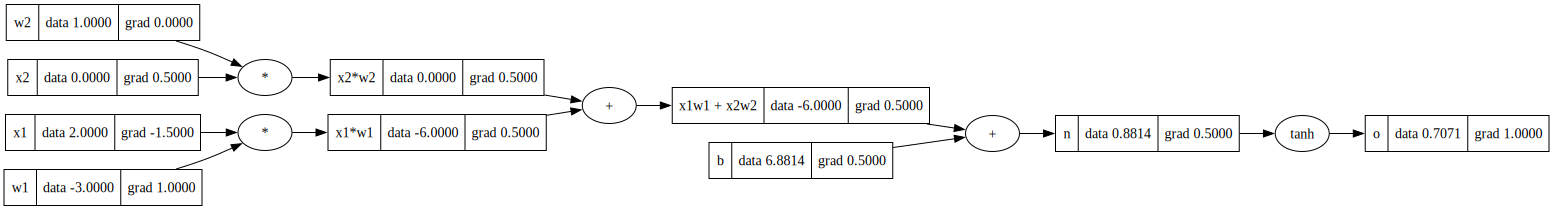

In [172]:
draw_dot(o)

remember that during backpropagation in a typical neural network setting, what we care about most is the derivative of the neurons on the weights specifically, since those are the ones we change for optimization


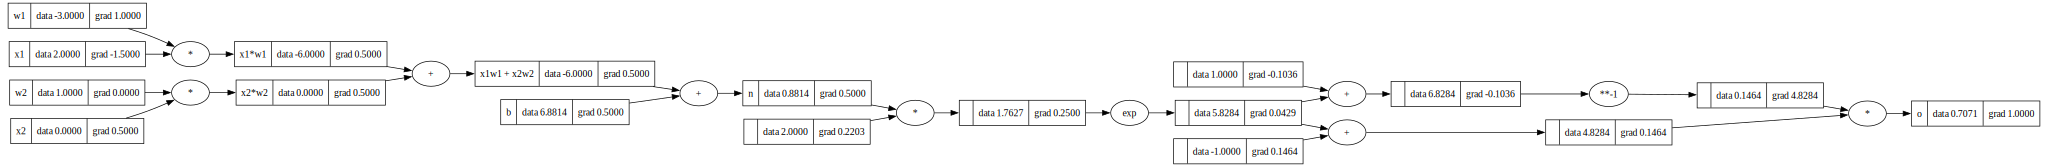

In [173]:
#inputs x1 and x2, which are two dimentional neurons
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias b
b = Value(6.8813735870195432, label = 'b')

#x1w1 + x2w2 + b -> weighted sum of inputs
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

#n is now the cell body without the activation function
n = x1w1x2w2 + b; n.label = 'n'
#------------------------#activation function
e = (2*n).exp()
o = (e-1) / (e+1)
#----------------------
o.label = 'o' # need to create my own tanh funciton that only uses times and adds

o.backward()
draw_dot(o)

# now using PyTorch

In [196]:
import torch
import random

In [185]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [187]:
######defining the value objects into pytorch tensors Values objects -> Tensors
x1 = torch.Tensor([2.0]). double()       ; x1.requires_grad = True #by default, leaf nodes are not required to have gradients
x2 = torch.Tensor([0.0]). double()       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]). double()     ; w1.requires_grad = True
w2 = torch.Tensor([1.0]). double()      ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]). double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # need to call item() to get the value out of the tensor
o.backward()

print('-------here we gooooo---------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
-------here we gooooo---------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [194]:
x2.grad

tensor([0.5000], dtype=torch.float64)

## can start building out a neural net

In [207]:
class Neuron:
    #this is the constructor
    def __init__(self, nin): #nin = number of inputs into the neuron
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        #w * x + b ( * is the dot product)
        # zip takes two iterators and creates a new iterator by pairing each element in 
        # the first iterator with the corresponding element in the second iterator
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    
    
class Layer:
    
    def __init__(self, nin, nout): #nouts -> number of outs of neurons that we want
        self.neurons = [Neuron(nin) for _ in range(nout)] #list of neurons
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs


class MLP: #takes number of nin inputs
    def __init__(self, nin, nouts): #but now we will take a list of nouts
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] #iterate over consecutive pairs
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


x = [2.0, 3.0, -1.0] #input layer: a three dimensional input
n = MLP(3, [4,4,1]) #want 3 inputs into two layers of 4 and 1 output
n(x)

Value(data=0.8964447701794214)

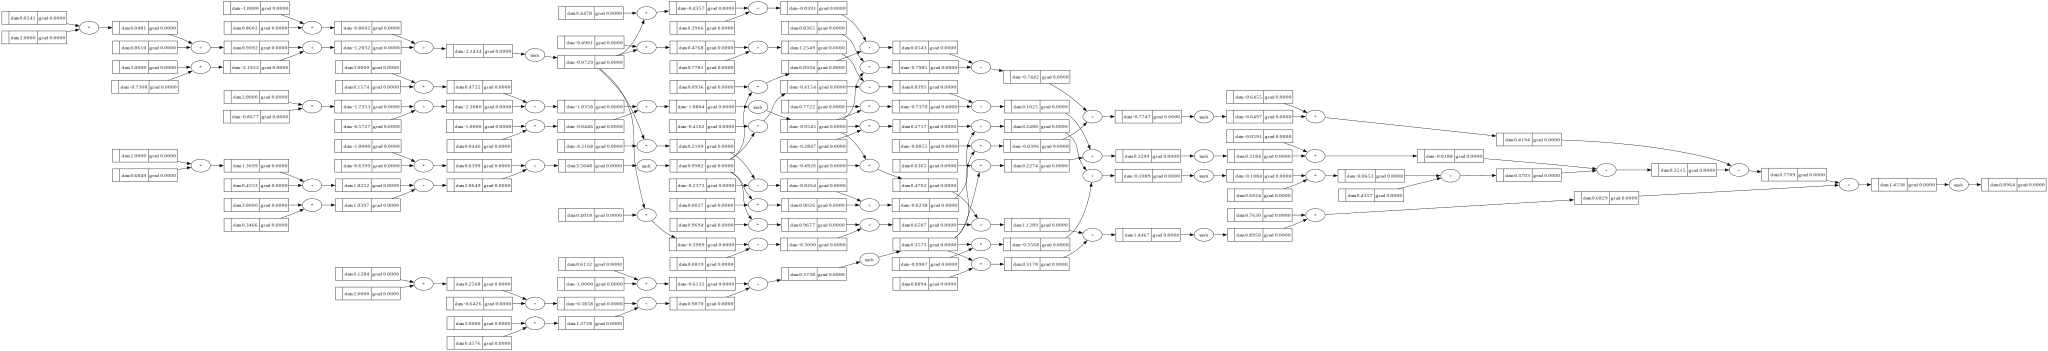

In [208]:
draw_dot(n(x))

In [212]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
] # 4 possible inputs into the neural net

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.8964447701794214),
 Value(data=0.8444407488959488),
 Value(data=0.583211534703519),
 Value(data=0.9162006350278755)]